In [91]:
import numpy as np
import matplotlib.pyplot as plt

In [92]:
N = 2 # mini-batch size
H = 3 # vector dim in hidden state
T = 20 # length of time-series data

dh = np.ones((N, H))
np.random.seed(3)
Wh = np.random.randn(H, H)

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

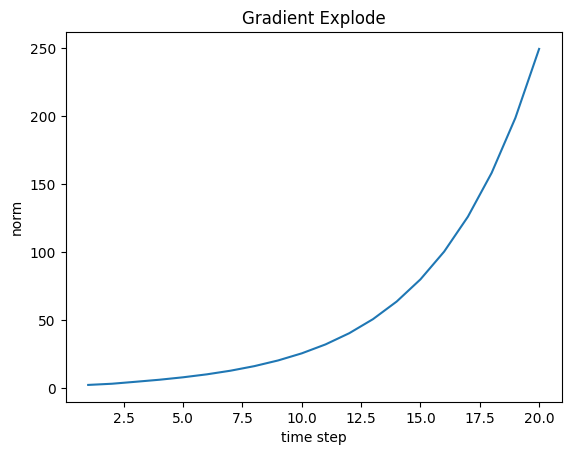

In [93]:
T = np.arange(1, 21)

plt.plot(T, norm_list)
plt.title("Gradient Explode")
plt.xlabel("time step")
plt.ylabel("norm");

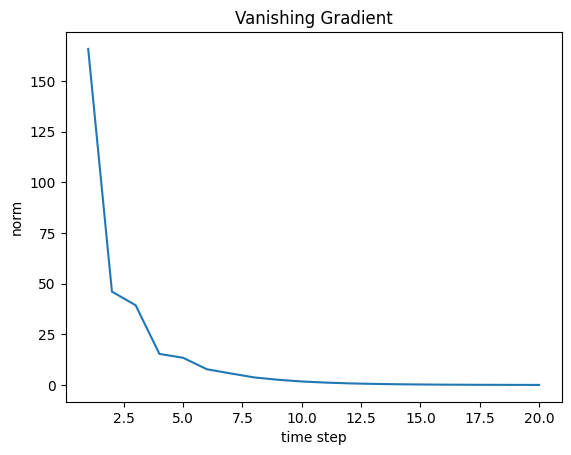

In [94]:
T = 20
Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

T = np.arange(1, 21)
plt.plot(T, norm_list)
plt.title("Vanishing Gradient")
plt.xlabel("time step")
plt.ylabel("norm");

In [95]:
# How to fix this
# Use Gradient Clipping
dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0 # theshold

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad**2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

In [97]:
# Simple LSTM model
import sys
sys.path.append('..')
from common.functions import *

class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        A = np.matmul(x, Wx) + np.matmul(h_prev, Wh) + b

        # slice
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

In [98]:
# Time LSTM
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape # N: Batch size, T: Time step, D: Dimmension of input, xs: input
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f') # hs: output

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h,  self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
            self.dh = dh
            return dxs

        def set_state(self, h, c=None):
            self.h, self.c = h, c

        def reset_state(self):
            self.h, self.c = None, None

In [99]:
# Language Model using LSTM
import sys
sys.path.append('..')
from common.time_layers import *
import pickle

class LSTMLM:
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # Initializing weights
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4*H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4*H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4*H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # Layers
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # Adding weights and gradients in list
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 9999.33
| 에폭 1 |  반복 21 / 1327 | 시간 6[s] | 퍼플렉서티 2938.24
| 에폭 1 |  반복 41 / 1327 | 시간 15[s] | 퍼플렉서티 1245.11
| 에폭 1 |  반복 61 / 1327 | 시간 23[s] | 퍼플렉서티 962.10
| 에폭 1 |  반복 81 / 1327 | 시간 32[s] | 퍼플렉서티 840.04
| 에폭 1 |  반복 101 / 1327 | 시간 42[s] | 퍼플렉서티 650.75
| 에폭 1 |  반복 121 / 1327 | 시간 48[s] | 퍼플렉서티 666.80
| 에폭 1 |  반복 141 / 1327 | 시간 56[s] | 퍼플렉서티 603.98
| 에폭 1 |  반복 161 / 1327 | 시간 65[s] | 퍼플렉서티 568.87
| 에폭 1 |  반복 181 / 1327 | 시간 74[s] | 퍼플렉서티 588.64
| 에폭 1 |  반복 201 / 1327 | 시간 84[s] | 퍼플렉서티 516.81
| 에폭 1 |  반복 221 / 1327 | 시간 90[s] | 퍼플렉서티 492.33
| 에폭 1 |  반복 241 / 1327 | 시간 98[s] | 퍼플렉서티 455.04
| 에폭 1 |  반복 261 / 1327 | 시간 105[s] | 퍼플렉서티 468.42
| 에폭 1 |  반복 281 / 1327 | 시간 112[s] | 퍼플렉서티 457.84
| 에폭 1 |  반복 301 / 1327 | 시간 118[s] | 퍼플렉서티 390.37
| 에폭 1 |  반복 321 / 1327 | 시간 125[s] | 퍼플렉서티 350.40
| 에폭 1 |  반복 341 / 1327 | 시간 135[s] | 퍼플렉서티 406.62
| 에폭 1 |  반복 361 / 1327 | 시간 145[s] | 퍼플렉서티 408.54
| 에폭 1 |  반복 381 / 1327 | 시간 155[s] | 퍼플렉서티 339.2

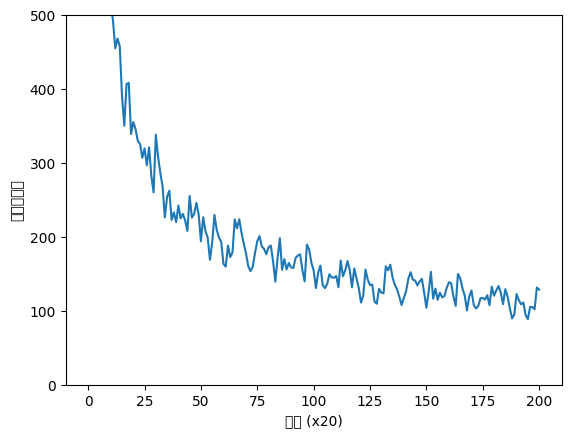

퍼플렉서티 평가 중 ...
234 / 235
Perplexity of test data: 139.89619205087308


In [103]:
# Training
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from rnnlm import Rnnlm

# Hyperparameters
batch_size = 20
wordvec_size = 100
hidden_size = 100
time_size = 35
lr = 20.0
max_epoch = 3
max_grad = 0.25

# Reading training data
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# Creating model
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# With Gradient Clipping
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0, 500))

# Test
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print(f"Perplexity of test data: {ppl_test}")

In [104]:
# Better LSTMLM with 2-layer LSTM, dropout, and weight tying
import sys
sys.path.append('..')
from common.time_layers import *
from common.np import *
from common.base_model import BaseModel

class BetterLSTMLM(BaseModel):
  def __init__(self, vocab_size=10000, wordvec_size=650, hidden_size=650, dropout_ratio=0.5):
    V, D, H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn

    embed_W = (rn(V, D) / 100).astype('f')
    lstm_Wx1 = (rn(D, 4*H) / np.sqrt(D)).astype('f')
    lstm_Wh1 = (rn(H, 4*H) / np.sqrt(H)).astype('f')
    lstm_b1 = np.zeros(4*H).astype('f')
    lstm_Wx2 = (rn(H, 4*H) / np.sqrt(H)).astype('f')
    lstm_Wh2 = (rn(H, 4*H) / np.sqrt(H)).astype('f')
    lstm_b2 = np.zeros(4*H).astype('f')
    affine_b = np.zeros(V).astype('f')

    # Improvements
    # 2 LSTM Layers
    # Dropout
    # Weight tying
    self.layers = [
        TimeEmbedding(embed_W),
        TimeDropout(dropout_ratio),
        TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
        TimeDropout(dropout_ratio),
        TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
        TimeDropout(dropout_ratio),
        TimeAffine(embed_W.T, affine_b) # Weight tying
    ]
    self.loss_layer = TimeSoftmaxWithLoss()
    self.lstm_layers = [self.layers[2], self.layers[4]]
    self.drop_layers = [self.layers[1], self.layers[5]]

    self.params, self.grads = [], []
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads

  def predict(self, xs, train_flg=False):
    for layer in self.drop_layers:
      layer.train_flg = train_flg
    for layer in self.layers:
      xs = layer.forward(xs)
    return xs

  def forward(self, xs, ts, train_flg=True):
    score = self.predict(xs, train_flg)
    loss = self.loss_layer.forward(score, ts)
    return loss

  def backward(self, dout=1):
    dout = self.loss_layer.backward(dout)
    for layer in reversed(self.layers):
      dout = layer.backward(dout)
    return dout

  def reset_state(self):
    for layer in self.lstm_layers:
      layer.rest_state()